# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import torch
from torch import nn, optim, cuda, device as Device
from torch.nn import functional as F

from unityagents import UnityEnvironment
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import random
from collections import namedtuple, deque

device = Device("cuda:0" if cuda.is_available() else "cpu")

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = UnityEnvironment(file_name="./Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
action_size = brain.vector_action_space_size
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [3]:
# Hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [4]:
class DQNetwork(nn.Module):
    """
    This is my Deep Q Network.
    """
    
    def __init__(self, state_size, action_size):
        """
        Initializer for my Network
        """
        super(DQNetwork, self).__init__()
        hidden_layers = [256, 256, 128, 64]
        layers = []
        layers.append(nn.Linear(in_features=state_size, out_features=hidden_layers[0]))
        for in_f, out_f in zip(hidden_layers[:-1], hidden_layers[1:]):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(in_f, out_f))
        
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=hidden_layers[-1], out_features=action_size))
        layers.append(nn.Softmax(dim=1))
            
        self.model = nn.Sequential(*layers)
    
    def forward(self, state):
        """
        My forward step implementation
        """
        return self.model(state)
    

In [5]:
class ReplayBuffer:
    """
    Fixed-size buffer to store experience tuples.
    """
    
    def __init__(self, action_size, buffer_size, batch_size):
        """
        Initialize the replay buffer.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
    
    def add(self, state, action, reward, next_state, done):
        """
        Add experience to the memory
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """
        Gets a random batch of experience from memory
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """
        Returns the current size of the memory
        """
        return len(self.memory)


In [6]:
class Agent():
    """
    This is the agent interacts with the environment and learns.
    """
    def __init__(self, state_size, action_size):
        """
        Initializes my agent.
        """
        self.state_size = state_size
        self.action_size = action_size
        
        # DQ Network
        self.qnetwork_local = DQNetwork(state_size, action_size).to(device)
        self.qnetwork_target = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.time_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """
        My step function: should add here memory replay and
        another related stuff.
        """
        self.memory.add(state, action, reward, next_state, done)
        
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    
    
    def act(self, state, eps=0.0):
        """
        Returns the next action.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
            
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def learn(self, experiences, gamma):
        """
        Update value parameters using the provided experience batch.
        """
        states, actions, rewards, next_states, dones = experiences
        
        Q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)
        
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.qnetwork_local(states).gather(1, actions)
                                   
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
    
    def soft_update(self, local_model, target_model, tau):
        """
        Soft update the model parameters.
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
                                   

### Training the agent

In [7]:
agent = Agent(state_size=37, action_size=action_size)

Episode 100	Average Score: 0.04
Episode 200	Average Score: 1.13
Episode 300	Average Score: 4.21
Episode 400	Average Score: 6.74
Episode 500	Average Score: 6.07
Episode 600	Average Score: 6.35
Episode 700	Average Score: 7.71
Episode 800	Average Score: 7.16
Episode 900	Average Score: 6.84
Episode 1000	Average Score: 7.25
Episode 1100	Average Score: 7.71
Episode 1200	Average Score: 6.68
Episode 1300	Average Score: 6.93
Episode 1400	Average Score: 7.90
Episode 1500	Average Score: 7.29
Episode 1600	Average Score: 7.29
Episode 1700	Average Score: 8.01
Episode 1800	Average Score: 7.30
Episode 1900	Average Score: 9.72
Episode 2000	Average Score: 7.79
Episode 2100	Average Score: 9.43
Episode 2200	Average Score: 10.15
Episode 2300	Average Score: 9.527
Episode 2400	Average Score: 8.62
Episode 2500	Average Score: 9.834
Episode 2600	Average Score: 9.47
Episode 2700	Average Score: 10.23
Episode 2800	Average Score: 10.75
Episode 2900	Average Score: 10.78
Episode 3000	Average Score: 10.09
Episode 3100

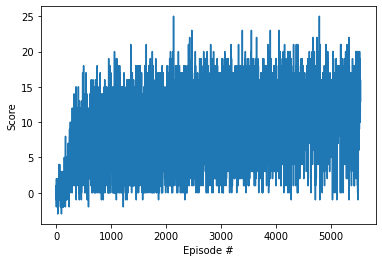

In [8]:
def dqn(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning.
    """
    scores=[]
    scores_window=deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        while True:
            action = agent.act(state, eps)        # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(7000)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 8.0


When finished, you can close the environment.

In [10]:
env.close()

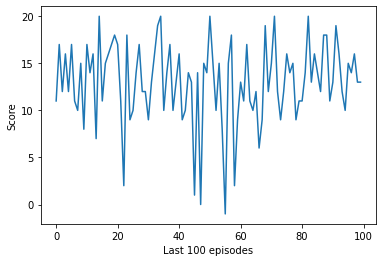

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(100), scores[-100:])
plt.ylabel('Score')
plt.xlabel('Last 100 episodes')
plt.show()